# Dissertation: MSc Health Data Science 2024-2025

Author: Laura Khaukha

Python version: Python 3.10

Description: Please note the subsequent IPython implements the core metholodly for the dissertation project (see section 2.0 in the correspodning text), titled:

Schema-Augmented Prompt Engineering for Text-to-SQL Generation over SNOMED CT with T5-small

## Section 1.0: Loading/Preprocessing the NHS TRUD DATA into a SQLite database

In [ ]:
# Installing relevant packages, where neccessary
# Keep in mind, in this code block it is assumed that the user has not installed any of the requisite packages, included for reproducity reasons.
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pprint
!pip install sqlite3
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install ragas datacompy sqlglot datasets

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [ ]:
# Loading all neceesssary packages in preperation for the code
# Please run this code block for effective and efficient running of the subsequent code
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import sqlite3
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import io, math, warnings, sqlite3
from difflib import SequenceMatcher
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import DataCompyScore, LLMSQLEquivalence
from datasets import Dataset
import sqlglot
from sqlglot import expressions as sx
import re

In [ ]:
#As Google Collab is used in this analysis,
#this step was used to connect to google drive, where the data was stored locally, in order to import it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Standardising/Defining the database/dataset and table names: Descriptions relationships language refset
#This was done due to prior challenges in
DB_PATH="snomedct_data.db"
DESC_TBL="TRUD_descriptiontable"
REL_TBL="TRUD_relationshiptable"
LANG_TBL="TRUD_language_refset"

1.1 Section: Loading/Preprocessing the SNOMED-CT data from NHS TRUD into the SQLlite dataset

- The preprocessing requirements are outliened and reasoned in the corresponding text in section 2.3

In [ ]:
# Processing and Loading the description table
decrip_df = pd.read_csv("Terminology/sct2_Description_UKCLSnapshot-en_GB1000000_20241120.txt", sep="\t", dtype=str)
decrip_df.columns = map(str.lower, decrip_df.columns) #Standardise column names, making everything lowercase for consistency
decrip_df = decrip_df[decrip_df["active"] == "1"] #Filtering the active entries to include for the model, take away the inactive ones

#Processing and loading the relationships table
rela_df = pd.read_csv("SnomedCT_UKClinicalRF2_PRODUCTION_20241120T000001Z/Snapshot/Terminology/sct2_Relationship_UKCLSnapshot_GB1000000_20241120.txt", sep="\t", dtype=str)
rela_df.columns = map(str.lower, rela_df.columns) #Standardise column names, making everything lowercase for consistency
rela_df = rela_df[rela_df["active"] == "1"]  #Filtering the active entries to include for the model, take away the inactive ones

#Preprocessing and loading the language tables
langu_df = pd.read_csv("SnomedCT_UKClinicalRF2_PRODUCTION_20241120T000001Z/Snapshot/Refset/Language/der2_cRefset_LanguageUKCLSnapshot-en_GB1000000_20241120.txt",sep="\t", dtype=str)
langu_df.columns = langu_df.columns.str.lower()
langu_df = langu_df[langu_df["active"] == "1"]

# Creating and connecting to the SQLite database; Loading the Snomed-CT dataset, NHS from TRUD, into a SQLite database
conn = sqlite3.connect(DB_PATH)

# Rewriting the imported dataframes to SQLite tables
decrip_df.to_sql(DESC_TBL, conn, if_exists="replace", index=False)
rela_df.to_sql(REL_TBL,  conn, if_exists="replace", index=False)
langu_df.to_sql(LANG_TBL, conn, if_exists="replace", index=False)

#commiting the changes made to the DB_Path database, defined upstream of the code, and closing the connection
conn.commit()
#Viewing whether the changes have been succesfully committed
print("SQLite tables:",DB_PATH,"tables:",DESC_TBL,REL_TBL,LANG_TBL)
conn.close()

SQLite tables: snomedct_data.db tables: TRUD_descriptiontable TRUD_relationshiptable TRUD_language_refset


In [ ]:
#inspecting SQLite database contents,
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cur.fetchall())

#Looking at the insital 10 rows to verify
sqllite_df = pd.read_sql_query("SELECT * FROM TRUD_descriptiontable LIMIT 10", conn)
print(sqllite_df.head())

#Closing the connection
conn.close()

[('TRUD_descriptiontable',), ('TRUD_relationshiptable',), ('TRUD_language_refset',)]
            id effectivetime active            moduleid       conceptid  \
0  11000000117      20040131      1  999000011000000103  20881000000105   
1  21000000111      20040131      1  999000011000000103     11000000101   
2  21000237110      20230607      1  999000011000000103    861000237103   
3  31000000113      20040131      1  999000011000000103  20891000000107   
4  31000237112      20230607      1  999000011000000103   6561000237105   

  languagecode              typeid  \
0           en  900000000000013009   
1           en  900000000000013009   
2           en  900000000000003001   
3           en  900000000000013009   
4           en  900000000000013009   

                                                term  casesignificanceid  
0                           Read Code Administration  900000000000020002  
1                         Read Code Administration 1  900000000000020002  
2  Mass co

## Section 2.0 EDA (Exploratory Data Analysis)

In [ ]:
#Gaining initial insights on the dataset: Viewing the dataset
conn_1 = sqlite3.connect(DB_PATH)
pd.read_sql_query("SELECT * FROM TRUD_descriptiontable LIMIT 5", conn_1)

,id,effectivetime,active,moduleid,conceptid,languagecode,typeid,term,casesignificanceid
0,11000000117,20040131,1,999000011000000103,20881000000105,en,900000000000013009,Read Code Administration,900000000000020002
1,21000000111,20040131,1,999000011000000103,11000000101,en,900000000000013009,Read Code Administration 1,900000000000020002
2,21000237110,20230607,1,999000011000000103,861000237103,en,900000000000003001,Mass concentration of drug in urine (observabl...,900000000000020002
3,31000000113,20040131,1,999000011000000103,20891000000107,en,900000000000013009,Read Code Administration 2,900000000000020002
4,31000237112,20230607,1,999000011000000103,6561000237105,en,900000000000013009,Calcium percent in calculus,900000000000020002


In [ ]:
#Similarily,finding terms most commonnly used in the dataseet, for prompt generation in section 3.0 of the script
sql = """SELECT term, COUNT(*) as frequency FROM TRUD_descriptiontable GROUP BY term ORDER BY frequency DESC LIMIT 20"""
temrs_most = pd.read_sql_query(sql, conn)
temrs_most

,term,frequency
0,Hypodermic needle injury,23
1,Accident caused by sharp-edged object,22
2,High cost drugs,16
3,Maltreatment,15
4,High cost chemotherapy drugs,15
5,Transarterial approach,14
6,Reconstruction of cranial defect,14
7,Upper limb,12
8,Excision of lesion of brain tissue,12
9,Distraction osteogenesis of bones of skull,12


# Section 3: Manually creating the NL-SQL example categories

 - Manually creating the NL-SQL example categories (Corresponding to the Method section 3.4, Table 1 in the Text), in preperation for    
   the evalaution of shema-augmented prompting on the SNOMED CT data,
  via both few-shot (See Section:...) and zero-shot learning with the specific varaint of the T5-small model (See Section: ....).
  
- Overview of the tasks each gold standard example category aims to  
  fullfill (Aiming to reflect common Database to SNOMED CT funciotning):

* Category 1: Concept Retrieval of human-readable Terms
* Category 2: Synonym and Description Lookup
* Category 3: TypeID and ConceptID Extraction from Term
* Category 4: Hierarchical Relationship Exploration
* Category 5: Aggregation and Calculation-based Queries
* Category 6: Module ID-Based Filtering

In [ ]:
slq_promts_category1 = [
    ("What is the preferred term for concept ID 466891000000108?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '466891000000108' AND typeid = '900000000000003001'"),
    ("What is the full name for concept ID 386721000000105?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '386721000000105' AND typeid = '900000000000003001'"),
    ("Find the preferred name of concept ID 413681000000103.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '413681000000103' AND typeid = '900000000000013009'"),
    ("What is the English name of concept ID 466871000000109 ?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '466871000000109' AND languagecode = 'en' AND typeid = '900000000000003001'"),
    ("Give the preferred description of concept ID 470791000000108.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '470791000000108' AND typeid = '900000000000003001'"),
    ("What description is used as the preferred term for concept ID 368851000000106?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '368851000000106' AND typeid = '900000000000003001'"),
    ("What is the label of concept 401991000000109?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '401991000000109' AND typeid = '900000000000003001'"),
    ("Get the preferred English label for conceptID 431821000000108.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '431821000000108' AND typeid = '900000000000003001' AND languagecode = 'en'"),
    ("What name is preferred for the concept 443791000000100?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '443791000000100' AND typeid = '900000000000013009'"),
    ("Give me the preferred description for concept 467081000000103.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '467081000000103' AND typeid = '900000000000003001'"),
    ("Which term is listed as preferred for concept 401881000000100?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '401881000000100' AND typeid = '900000000000003001'"),
    ("For concept ID 465351000000104 what is the preferred term ?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '465351000000104' AND typeid = '900000000000003001'"),
    ("Show me which term corresponds to conceptid 271411000000102",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '271411000000102' AND typeid = '900000000000013009'"),
    ("Provide the english term of concept ID 441901000000108 ?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '441901000000108' AND languagecode = 'en' AND typeid = '900000000000003001'"),
    ("Provide the preferred description for the concept ID 19551000000101.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '19551000000101' AND typeid = '900000000000003001'"),
    ("Which descriptions are used for concept ID 368951000000101?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '368951000000101' AND typeid = '900000000000003001'"),
    ("Retrieve the label of concept 401761000000100?",
     "SELECT term FROM TRUD_descriptiontable WHERE concecptid = '401761000000100' AND typeid = '900000000000003001'"),
    ("I want the english term for concept ID 467211000000103	.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '467211000000103' AND typeid = '900000000000003001' AND languagecode = 'en'"),
    ("Which preferred name corresponds to concept 20121000000101?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '20121000000101' AND typeid = '900000000000013009'"),
    ("Find the description for concept 253571000000106.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '253571000000106' AND typeid = '900000000000003001'")]

In [ ]:
sql_promts_category2 = [
    ("What are all known synonyms for concept ID 427301000000100.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '427301000000100'"),
    ("List all the different descriptions for concept 270721000000106?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '270721000000106'"),
    ("Get all English terms for the concept ID 452161000000101.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '452161000000101' AND languagecode = 'en'"),
    ("Retrieve all labels for concept ID 411771000000105.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '411771000000105'"),
    ("Show all descriptions including synonyms for concept 441591000000105.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '441591000000105'"),
    ("What are the known terms for concept ID 470961000000100?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '470961000000100'"),
    ("Give me all descriptions linked to concept 491431000000104.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '491431000000104"),
    ("Get every English label for concept ID 401971000000105.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '401971000000105' AND languagecode = 'en'"),
    ("Return all terms used to describe concept 486081000000102.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '486081000000102'"),
    ("List every description for concept 418751000000106.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '418751000000106'"),
    ("Find every synonym for concept ID 487501000000104.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '487501000000104'"),
    ("Show all the descriptions for concept 271321000000100?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '271321000000100'"),
    ("Get all English terms for the concept ID 271751000000109.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '271751000000109' AND languagecode = 'en'"),
    ("I want all labels for concept ID 455621000000108.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '455621000000108'"),
    ("Display all the descriptions including synonyms for concept 368961000000103",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '368961000000103'"),
    ("Find all the terms associated with conceptID 455821000000109?",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '455821000000109'"),
    ("Fetch all the terms linked to concept 467251000000104.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '467251000000104"),
    ("Provide each english label for concept ID 255871000000109.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '255871000000109' AND languagecode = 'en'"),
    ("Return all terms used to describe concept 443991000000102.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '443991000000102'"),
    ("List every description for concept 467591000000109.",
     "SELECT term FROM TRUD_descriptiontable WHERE conceptid = '467591000000109'")]

In [ ]:
sql_promts_category3 = [
    ("What is the typeid associated with 'Hypodermic needle injury'?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Hypodermic needle injury'"),
    ("Is 'Accident caused by sharp-edged object' a synonym or a preferred term?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Accident caused by sharp-edged object'"),
    ("Retrieve the typeid for the term 'High cost drugs'.",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'High cost drugs'"),
    ("What is the type for the description 'Maltreatment'?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Maltreatment'"),
    ("Provide the description type of 'High cost chemotherapy drugs'.",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'High cost chemotherapy drugs'"),
    ("What is the typeid for the term 'Transarterial approach'?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Transarterial approach'"),
    ("Which type ID corresponds to the term 'Reconstruction of cranial defect'?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Reconstruction of cranial defect'"),
    ("What typeid is 'Upper limb' ?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Upper limb'"),
    ("Find the typeid for 'Excision of lesion of brain tissue'.",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Excision of lesion of brain tissue' "),
    ("What is the description type for 'Distraction osteogenesis of bones of skull'?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Distraction osteogenesis of bones of skull'"),
    ("Find the conceptid for 'Operations on bones of skull'?",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Operations on bones of skull'"),
    ("Is 'Operations for disorders of sex development' a synonym or a preferred term?",
     "SELECT typeid FROM TRUD_descriptiontable WHERE term = 'Operations for disorders of sex development'"),
    ("List the conceptid's associated with the term 'Destruction of fetus'.",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Destruction of fetus'"),
    ("What is the conceptid for 'Wound microscopy, culture and sensitivities'?",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Wound microscopy, culture and sensitivities'"),
    ("Display the conceptid for'Urine maltose level'.",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Urine maltose level'"),
    ("Which concpetid corresponds with the term 'Urinary microscopy, culture and sensitivities'?",
     "SELECT concpetid FROM TRUD_descriptiontable WHERE term = 'Urinary microscopy, culture and sensitivities'"),
    ("Which conceptid is asssocaited with the term 'Treponema pallidum particle agglutination test'?",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Treponema pallidum particle agglutination test'"),
    ("Under what conceptid is 'Transplantation of stomach' ?",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Transplantation of stomach'"),
    ("Return the conceptid for 'Therapeutic endoscopic operations on nasal cavity'.",
     "SELECT conceptid FROM TRUD_descriptiontable WHERE term = 'Therapeutic endoscopic operations on nasal cavity'"),
    ("Which conceptid is 'Sickle solubility test'?",
     "SELECT conceptid  FROM TRUD_descriptiontable WHERE term = 'Sickle solubility test'")]

In [ ]:
sql_prompts_category4 = [
    ("Which concepts are associated with concept ID 466891000000108?",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '466891000000108'"),
    ("Provide the destination for  386721000000105.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '386721000000105'"),
    ("What are the source concepts pointing to 256691000000101?",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '256691000000101'"),
    ("Provide all the sources concept 413681000000103 connects to.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '413681000000103'"),
    ("Which concepts are the targets of 466871000000109?",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '466871000000109'"),
    ("Show all concepts that link to destination 4707910000001081.",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '470791000000108'"),
    ("Identify the source concepts associated with destination ID 368851000000106.",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '368851000000106'"),
    ("Which concepts are connected to 401991000000109 as destination?",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '401991000000109'"),
    ("Show all concepts related from source 468611000000102.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '468611000000102'"),
    ("List the concepts that 431821000000108 refers to.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '431821000000108'"),
    ("Which concepts reference 443791000000100 as a destination?",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '443791000000100'"),
    ("List all destination concepts for concept 467081000000103.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '467081000000103'"),
    ("Get all related concepts from 401881000000100.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '401881000000100'"),
    ("Find all links that point to destination 465351000000104.",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '465351000000104'"),
    ("Return all source IDs for destination concept 271411000000102.",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '271411000000102'"),
    ("Find the destination ids that link to 441901000000108",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '441901000000108'"),
    ("Find all concepts that map to 19551000000101.",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '19551000000101'"),
    ("What are the source concepts that lead to 368951000000101?",
     "SELECT sourceid FROM TRUD_relationshiptable WHERE destinationid = '368951000000101'"),
    ("Give me all destination concepts connected from 401761000000100.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '401761000000100'"),
    ("List concepts related from 467211000000103.",
     "SELECT destinationid FROM TRUD_relationshiptable WHERE sourceid = '467211000000103'")]

In [ ]:
sql_prompts_category5= [
    ("How many distinct relationships exist in the table?",
     "SELECT COUNT(*) FROM TRUD_relationshiptable"),
    ("How many destination concepts are linked from concept ID 466891000000108?",
     "SELECT COUNT(destinationid) FROM TRUD_relationshiptable WHERE sourceid = '466891000000108'"),
    ("Count how many sourceids are assocaited with concept ID 368951000000101.",
     "SELECT COUNT(sourceid) FROM TRUD_relationshiptable WHERE destinationid = '368951000000101'"),
    ("Provide the total number of the unique sourceids from the relationship table.",
     "SELECT COUNT(DISTINCT sourceid) FROM TRUD_relationshiptable"),
    ("What is the maximum number of conceptids in the table?",
     "SELECT MAX(conceptid) FROM TRUD_descriptiontable"),
    ("What is the mimimum number of conceptid in the table?",
     "SELECT MIN(conceptid) FROM TRUD_descriptiontable"),
    ("How many destinationid's are present in the schema ?",
     "SELECT COUNT(destinationid) FROM TRUD_descriptiontable"),
    ("Find the sum of terms associated with the concpet id 466891000000108",
     "SELECT SUM(conceptid) FROM TRUD_relationshiptable WHERE conceptid = 466891000000108"),
    ("Provide total count of conceptids that start with the number 4",
     "SELECT COUNT(conceptid) FROM TRUD_relationshiptable WHERE conceptid LIKE '4%'"),
    ("Retrive total number of terms that start with the number heart",
     "SELECT COUNT(term) FROM TRUD_relationshiptable WHERE term LIKE = 'heart%'"),
    ("How many terms with the conceptid 466891000000108, end with injury?",
      "SELECT terms FROM TRUD_relationshiptable WHERE term LIKE = '%injury' AND conceptid = 466891000000108"),  #11
    ("Find the maximum number of relationships per source ID.",
     "SELECT MAX(relationship_count) FROM (SELECT sourceid, COUNT(*) AS relationship_count FROM TRUD_relationshiptable GROUP BY sourceid) AS counts"),
    ("Count the number of relationships per type ID.",
     "SELECT typeid, COUNT(*) FROM TRUD_relationshiptable GROUP BY typeid"),
    ("Count how many descriptions contain the word 'disease'",
     "SELECT COUNT(*) FROM TRUD_descriptiontable WHERE term LIKE '%disease%'"),
    ("What is the number of relationships per type ID ?.",
     "SELECT typeid, COUNT(*) FROM TRUD_relationshiptable GROUP BY typeid"),
    ("Find the source ID with the fewest destination concepts.",
     "SELECT sourceid, COUNT(destinationid) AS count_dest FROM TRUD_relationshiptable GROUP BY sourceid ORDER BY count_dest ASC LIMIT 1"),
    ("Get the total number of descriptions per concept ID.",
     "SELECT conceptid, COUNT(*) AS description_count FROM TRUD_descriptiontable GROUP BY conceptid"),
    ("How many terms are associated with each language code?",
     "SELECT languagecode, COUNT(*) FROM TRUD_descriptiontable GROUP BY languagecode"),
    ("Which language code has the highest number of terms?",
     "SELECT languagecode, COUNT(*) AS term_count FROM TRUD_descriptiontable GROUP BY languagecode ORDER BY term_count DESC LIMIT 1"),
    ("What is the maximum concept ID value in the description table?",
     "SELECT MAX(CAST(conceptid AS UNSIGNED)) FROM TRUD_descriptiontable"),
    ("What is the minimum concept ID value in the description table?",
     "SELECT MIN(CAST(conceptid AS UNSIGNED)) FROM TRUD_descriptiontable")]

In [ ]:
sql_prompts_category6 = [("What are all terms with module ID 999000041000000102?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000041000000102'"),
                         ("What are all terms with module ID 900000000000207008?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '900000000000207008'"),
                         ("What are all terms with module ID 999000031000000106?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000031000000106'"),
                         ("What are all terms with module ID 999000021000000104?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000021000000104'"),
                         ("What are all terms with module ID 999000011000000101?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000011000000101'"),
                         ("What are all terms with module ID 999000001000000107?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000001000000107'"),
                         ("What are all terms with module ID 999000051000000100?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000051000000100'"),
                         ("What are all terms with module ID 999000061000000105?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000061000000105'"),
                         ("What are all terms with module ID 999000071000000108?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000071000000108'"),
                         ("What are all terms with module ID 999000081000000103?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000081000000103'"),
                         ("What are all terms with module ID 999000091000000106?",
                           "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000091000000106'"),
                        ("What are all terms with module ID 999000101000000109?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000101000000109'"),
                         ("What are all terms with module ID 999000111000000105?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000111000000105'"),
                         ("What are all terms with module ID 999000121000000108?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000121000000108'"),
                         ("What are all terms with module ID 999000131000000101?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000131000000101'"),
                         ("What are all terms with module ID 999000141000000103?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000141000000103'"),
                         ("What are all terms with module ID 999000211000000107?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000211000000107'"),
                         ("What are all terms with module ID 999000221000000109?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000221000000109'"),
                         ("What are all terms with module ID 999000231000000104?",
                          "SELECT term FROM TRUD_descriptiontable WHERE moduleid = '999000231000000104'")]

# Section 4 Descritpitve statisitcs

- The findings of the  descriptive anlysis, are outlined in section 3.2
  in the results section page 13.

In [ ]:
#Wrapping the SQL example categories, NL-SQL paris, to humanreadable cateory names, needed for the descriptive statstics section
categories = {"Concept lookups (Cat: 1)":slq_promts_category1,
              "Synonyms & descriptions (Cat:2)":sql_promts_category2,
              "typeId & conceptID by term (Cat3)":sql_promts_category3,
              "Concept relationships (Cat4)":sql_prompts_category4,
              "aggregation &counts (Cat5)":sql_prompts_category5,
              "ModuleId filters (Cat6)":sql_prompts_category6,}

In [ ]:
#Definining the function validor, to ensure all the cateogories are in the required formate
def _validat_(x):
    """The following function, validator, checks whether an object is valid,
     example (NL-SQL) tuple (this is the later required in the prompting pipeliens
     """
    return (
        isinstance(x, tuple)
        and len(x) ==2
        and all(isinstance(t, str) and len(t.strip()) > 0 for t in x))

#Defining empty lists for to append descriptive analysis into
r_=[]
inval_r = []

#Looping through each NL-SQL category, computing decriptive statistics
for cateogryname, i in categories.items():
    nrofitems=len(i)
    nrofval =sum(_validat_(x) for x in i)
    n_inval= nrofitems - nrofval
    r_.append({
        "Category": cateogryname,
        "Number(Nr.)of items": nrofitems,
        "Number (Nr.)of valid (NL-SQL pairs)":nrofval,
        "Number(Nr.) of invalid (NL-SQL pairs)": n_inval,
        "Percentage of valid NL-SQL examples":(nrofval / nrofitems) * 100 if nrofitems else 0.0,
    })

#Displaying the results to report in the corresponding dissertation text, in table 2 in section 3.2 on page 13
ds_f = pd.DataFrame(r_).sort_values("Category").reset_index(drop=True)
ds_f["Percentage of valid NL-SQL examples"] = ds_f["Percentage of valid NL-SQL examples"].round(1)
print("Table 2. Distribution of NL–SQL pairs by category")
display(ds_f)

Table 2. Distribution of NL–SQL pairs by category


,Category,Number(Nr.)of items,Number (Nr.)of valid (NL-SQL pairs),Number(Nr.) of invalid (NL-SQL pairs),Percentage of valid NL-SQL examples
0,Concept lookups (Cat: 1),20,20,0,100.0
1,Concept relationships (Cat4),20,20,0,100.0
2,ModuleId filters (Cat6),19,19,0,100.0
3,Synonyms & descriptions (Cat:2),20,20,0,100.0
4,aggregation &counts (Cat5),21,21,0,100.0
5,typeId & conceptID by term (Cat3),20,20,0,100.0


## Section 5: Importing the T5-small model: Evaluation functions


1.   Pretrained model Details can be found:
     https://huggingface.co/cssupport/t5-small-awesome-text-to-sql

     -  The reasoning behind choosing the T5-small may be found in the
        corresponding dissertation: See section 2.1 and figure 2 and its figure legend.

2.   The evaluation and helper functions for the both the few-shot and
     zero-shot pipelines are also defined in the following section.Though notbaly, within the few-shot pipeline especially helper function had to be specialised for the particular cateogory. These are accordinlgy, these are defined and used in the corresponding pipelines.

In [ ]:
#Importing the model into the environment
tokeniser = T5Tokenizer.from_pretrained('t5-small') #tokeniser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained('cssupport/t5-small-awesome-text-to-sql')
model = model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

Section 5.1: Defining helper functions,formatting reslults, converting NL into SQ

In [ ]:
#Function that takes NL input and ouputs SQL , for both zero and few shot pipeline
def gensql(inpt_pp):
  """ The following function leverages a specified model, and converts the inputs NL
    into a corresponding SQL query
  """
  inpt = tokeniser(inpt_pp, padding=True, truncation=True, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = model.generate(**inpt, max_length=512)
    return tokeniser.decode(outputs[0], skip_special_tokens=True)

#Formatting function for the obtained resutls
def runthesql_ctdf(sql: str, conn: sqlite3.Connection) -> pd.DataFrame | None:
    """
    The following gunction, executes an obtained SQL query agaisnt the database
    (Neccessary for the execuitabllity metrics), thereby returning the result as a dataframe.
    If execution has failed None is returend, while empty results return header only dataframe.
    """
    try:
        ot = pd.read_sql_query(sql, conn)
        ot = ot.astype(str)
        ot = ot.reindex(sorted(ot.columns), axis=1)
        if ot.shape[0] ==0:
            return ot.head(0)
        ot = ot.sort_values(list(ot.columns)).reset_index(drop=True)
        return ot
    except Exception:
        return None

#Fromatting the subsequent results dataframeinto CSV text
def dtcsvtxt(dt: pd.DataFrame | None) -> str:
    """
    The following function/step is neccessary to compute the DataCompy scores, as it
    converts the results dataframe into a CSVfile with header. Due to previous
    challenges encountered in computing the Datacompy scores, the function is designed so that
    an empty is never returned, and instead provides a messsage, indiating the that the obtained
    SQL query given is invalid/non runable.
    """
    if dt is None:
        return "not runnable sql"
    if dt.shape[0] ==0:
        return dt.head(0).to_csv(index=False)
    return dt.to_csv(index=False)

#Function used later to semantic equivalance, ensures standardised fromat
def sqlglotr(sql: str):
    """
    The follwoing function is critcial and aid the subsequent
    measuring semantic equivalance using sqlglot, through
    pareses a SELECT clause into a canonical representation.
    It captures which tables are involved, ignoring case and order.
    It uses a bollean to flag for the DISTINCT clause, morevoer it
    normalises SQL expressions selected by the query, with any aliases removed.
    Next normalises list of columns or expressions grouped by, ignoring order.
    Lastly, this function normamalsises the WHERE claue.
    Overall, this aids in measuring semantic equivalence by ignoring irrelvant differces
    in formatting or aliasing, caputuring the queries true intent wrt the reference set.
    """
    try:
        tr = sqlglot.parse_one(sql, read="sqlite")
    except Exception:
        return None
    #allowing answer for SELECT clause
    sl = tr.find(sx.Select)
    if sl is None:
        return None
    # Removing Order by, thereby ignoring roworder differences
    for ob in list(tr.find_all(sx.Order)):
        ob.parent.set("order", None)
    #lowercasing tables
    table = {t.name.lower() for t in tr.find_all(sx.Table)}
    #Flagging the dstinct clause
    isdistinct = bool(sl.args.get("distinct", False))
    # Removing aliases while normalising the SQL queries to strings,lastly putting these into set
    pjn = set()
    for e in sl.expressions:
        if isinstance(e, sx.Alias):
            e = e.this
        pjn.add(e.sql(dialect="sqlite", normalize=True).lower())
    # group by, normalising strings
    gb = sl.args.get("group")
    gp_n= set()
    if gb:
        for g in gb.expressions:
            gp_n.add(g.sql(dialect="sqlite", normalize=True).lower())
    #normasing the WHERE CLAUSE
    whexpr = sl.args.get("where")
    whn = whexpr.sql(dialect="sqlite", normalize=True).lower() if whexpr else ""
    # signature is a tuple of hashables
    return (frozenset(table),isdistinct, frozenset(pjn), frozenset(gp_n), whn)


def extractsql(text: str) -> str:
  """ the following function extract the generated SQL query usinng Regex logic"""
  t = text.strip()
  if ";" in t: t = t.split(";")[0]
  m = re.search(r"(?is)\bselect\b.*", t)
  return m.group(0).strip() if m else t

def valexecut(sql: str, conn: sqlite3.Connection):
    s = sql.strip().rstrip(";")
    if not re.match(r"(?is)^\s*(select|with)\b", s):
        return False, "Does not start with SELECT/WITH"
    try:
        conn.execute(f"EXPLAIN QUERY PLAN {s}")
        return True, "OK"
    except Exception as e:
        return False, f"EXPLAIN failed: {e}"
#Defining paramaters
nr_bm=6
max_tok=128
np_ngram = 3

def generatesqldecoderul(p):
    """Functions specfying the strict decoding rules for the model, while runing the model"""
    inputs = tokeniser(p, padding=False, truncation=False, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            num_beams=nr_bm,
            max_new_tokens=max_tok,
            no_repeat_ngram_size=np_ngram,
            early_stopping=True,
            pad_token_id=tokeniser.pad_token_id,
            bad_words_ids=Bd_w,
            do_sample=False,
        )
    return tokeniser.decode(out_ids[0], skip_special_tokens=True).strip()


5.2 Defining Evaluation metric functions: Used throughout both few & zero shot pipelies (Section 6 and 7), respectivly

In [ ]:
# Function to coput semantic equivalence using the aformentioned sqlglotr

def sqlglotsemanticequiv(asql: str, bsql: str) -> float:
    """
    The following function computes the semantic equivalence between the expected
    versus the obtained SQL queries. Its a binary metric, if the the semantic
    equivalence is has macthces, it returnes 1 otherwise the parsing failes, thereby
    returning 0, null
    """
    asig = sqlglotr(asql)
    bsig = sqlglotr(bsql)
    return 1.0 if (asig is not None and asig==bsig) else 0.0

#Adds the computeded semantic equivalence into a column in the results dataframse
def add_sqlglot_equiv(dtin: pd.DataFrame, execo: bool = True) -> pd.DataFrame:
    """
    The follwoing function adds the computeded semantic equivalence into a column,
    if execo is True, non-executable rows get NaN, thereby excluding them from means
    Otherwise every SQL results will be scored, if they fail to parse failures, null
    """
    dt = dtin.copy()
    vl = []
    for _, r in dt.iterrows():
        if execo and not r.get("exec_ok", False):
            vl.append(np.nan)
        else:
            vl.append(sqlglotsemanticequiv(r["generated_sql"], r["expected_sql"]))
    dt["sqlglot_equiv"] = vl
    return dt

def add_datacompy_scores(df_results: pd.DataFrame,conn: sqlite3.Connection,mode: str = "rows", metric: str = "f1") -> pd.DataFrame:
    """
    The following function adds a datacompy score column to the obtained results dataframse,
    comparing executed result sets. Hereby hanlding empty/non-executable cases
    to avoid NaNs and ZeroDivisionError, which had to implemented due to early work experiments.
    """
    # Normalize to ragas-expected
    mode = {"row":"rows","rows":"rows","column":"columns","columns":"columns"}[mode]
    metric = {"f1":"f1","precision":"precision","recall":"recall"}[metric]
    sr = DataCompyScore(mode=mode, metric=metric)
    out = df_results.copy()
    sr: list[float] = []
    for _, r in out.iterrows():
        exp_df = runthesql_ctdf(r["expected_sql"], conn)
        gen_df = runthesql_ctdf(r["generated_sql"], conn)
        #if SQL is non execuitbale return 0
        if exp_df is None or gen_df is None:
            sr.append(0.0)
            continue
        #Degenerating the empty cases
        n_exp, n_gen = exp_df.shape[0], gen_df.shape[0]
        if n_exp == 0 and n_gen == 0:
            sr.append(1.0)  # both empty → perfect match
            continue
        if n_gen == 0 and n_exp > 0:
            sr.append(1.0 if metric == "precision" else 0.0)
            continue
        if n_exp == 0 and n_gen > 0:
            sr.append(1.0 if metric == "recall" else 0.0)
            continue
        # Normal case
        sample = SingleTurnSample(
            response= dtcsvtxt(gen_df),
            reference= dtcsvtxt(exp_df)
        )
        try:
            s = sr.single_turn_score(sample)
            s = float(s)
            if math.isnan(s) or math.isinf(s):
                s = 0.0
        except ZeroDivisionError:
            s = 0.0
        except Exception:
            s = 0.0
        sr.append(s)
    out["datacompy_score"] = sr
    return out

 #Function which taggs those queries that are able to run against the database in the subsequent piplines
def tagexpairs(df_in: pd.DataFrame, conn) -> pd.DataFrame:
    """ The following function marks those SQL pairs that are able to
        run against the database """
    rows = []
    for _, r in df_in.iterrows():
        exp_df = runthesql_ctdf(r["expected_sql"], conn)
        gen_df = runthesql_ctdf(r["generated_sql"], conn)
        rows.append(((exp_df is not None), (gen_df is not None)))
    df_out = df_in.copy()
    exp_ok, gen_ok = zip(*rows)
    df_out["exec_ok"] = [eo and go for eo, go in zip(exp_ok, gen_ok)]
    return df_out

#Sequencence match metric (ASMS in the report)
def sequencematch(a: str, b: str) -> float:
  """ The following function computes the sequence match metric values in the susbequent pipelines: ASMS in the report"""
  return SequenceMatcher(None, a.lower(), b.lower()).ratio()

# Function to computes the exact match metric (EMA in the report)
def EMA(expsql: str, gensql: str, conn: sqlite3.Connection) -> bool:
    """The following function computes the exact match metric values in the subsequent pipelines"""
    expdt = runthesql_ctdf(expsql, conn)
    gendt = runthesql_ctdf(gensql, conn)
    return (expdt is not None) and (gendt is not None) and expdt.equals(gendt)

# Section 6.0: FEW-shot Prompting & Evaluation

Please note that this an extraction helper function for few-shot prompting was experimented with, which did improve the overall quality of the SQL results, across all metrics. However as it was considered not to reflect the models true peformance, instead inflated results values due to what was considered minor data leakage, it was removed.

Extractor function Looked like, however were adapted depening on the taks requirements for category 3 for instance the function was adapted to extract the term in the NL question:

def extractconceptidfNL(text: str):
    m = re.search(r"\b(\d{8,20})\b", text)
    return m.group(1) if m else None

Section 6.1 Few-shot prompting for Category 1


In [ ]:
#If not already open the database
conn_eval = sqlite3.connect(DB_PATH)

# Predefining th
FSN = "900000000000003001" #Predefining the Fully Specified Name
SYN = "900000000000013009" #Predefinong the Synonym/preferred term

In [ ]:
#The function below parses the NL questionto determine  extra filters for typeid and laguage codes, based on the aformentioned key words
def cat1filters(nl: str):
    """ The follwoing function parses the NL question, in oder to determine
    extra filters for typeid and laguage codes, based on the aformentioned
    key words. Thereby returning a list of column,value pairs.
    """
    t = nl.lower()
    wh= []
    if "full name" in t or "fsn" in t:
      wh.append(("typeid", FSN))
    elif "preferred" in t or "synonym" in t:
      wh.append(("typeid", SYN))
    else:# default to FSN if nothing else is specifiec
      wh.append(("typeid", FSN))
    if "english" in t:
        wh.append(("languagecode", "en"))
    return wh

# Establishing a set of rules the model must follow, created based on previous model struggles in SQL generation
def rulescat1(nl: str, concept_id: str | None) -> list[str]:
    """ The following function enforces rules the model must follow for category 1 SQL generation.
       This was created to guide the model in SQL generation, since the same errors were continously observed
       in SQl ouptuts from the model
    """
    muss = [
        "Only use table: TRUD_descriptiontable",
        "Only use columns: conceptid, term, typeid, languagecode",
    ]
    # Encforcing rules on conceptid: A common struggle observed when SQL was created
    if concept_id:
        muss.append("Concept IDs are TEXT: wrap them in single quotes")
        muss.append(f"Must use conceptid = '{concept_id}' exactly (do not change digits)")
    # NL-derived filters (FSN/SYN + optional English)
    muss += [f"Must include {col} = '{val}'" for col, val in cat1filters(nl)]
    # Retruning the textual description
    muss.append("Return exactly one SELECT statement (no comments)")
    muss.append("Do not use JOINs or other tables")
    muss.append("Must select 'term'")
    return muss

# The following function verifies if any of the aforementioned rules were violated (rulescat1)
def violates_cat1(sql: str, nl: str, concept_id: str) -> str:
    """The following function verifies if any of the aforementioned rules were
    violated during SQL generation"""
    s = sql.strip()
    lo = s.lower()
    #Select clause must be used
    if not re.match(r"(?is)^\s*select\b", s):
        return "Not a SELECT"
    #The correct table must be selected as follows
    if "trud_relationshiptable" in lo:
        return "Used TRUD_relationshiptable"
    if "trud_descriptiontable" not in lo:
        return "Missing TRUD_descriptiontable"
    #Preventing commonly detected hallucinated columns
    badcols = {
        "destinationid","sourceid","relationid","productid","prescriptionid",
        "termid","conjectid","concertid","label","description","column","columns","chart","table","name"
    }
    for c in badcols:
        if re.search(rf"\b{re.escape(c)}\b", lo):
            return f"Used non-existent/forbidden column '{c}'"
    # Requiring the exact match of the concept id
    if concept_id and not re.search(rf"conceptid\s*=\s*'{re.escape(concept_id)}'", s, flags=re.I):
        return "Missing or mutated conceptid predicate"
    # Requiring the mapped predicates from cat1filters
    for col, val in cat1filters(nl):
        if not re.search(rf"\b{re.escape(col)}\s*=\s*'{re.escape(val)}'", s, flags=re.I):
            return f"Missing required predicate {col} = '{val}'"
    #Term must also be selected
    if not re.search(r"(?is)^\s*select\s+(distinct\s+)?term\b", s):
        return "Must select 'term'"

    return ""

#specifying the schema hint
s_hint = (
    "You write SQLite SQL.\n"
    "Return exactly one SELECT statement. No comments.\n"
    "Use only the tables and columns shown. Do not invent tables or columns.")

#The following function formats the examples into the valid few-shot prompt format"
def buildfewpromptcat(eg, cuestion, schematxt, concept_id, k=3):
    """The following function formats the examples into the valid few-shot prompt format"""
    rul = "\n- ".join(rules5(cuestion, concept_id))
    dem = "\n\n".join([f"query for: {q}\nSQL: {sql.strip()}" for q, sql in eg[:k]])
    q = cuestion.strip().rstrip("?")
    return (
        f"{s_hint}\n\nRules:\n- {rul}\n\n"
        f"tables:\n{schematxt}\n\n"
        f"Here are some examples:\n{dem}\n\n"
        f"Now query for: {q}?\nSQL:"
    )

#Function below serves as a preventative measure for hallucation, by forbidding the model to generate certain coulumns names
def badwords(tokeniser):
    """ The following function aids the model in preveting hallucatoin, by forbidding the model to generate certain coulumns
           names: based on observations in previous attempts.
    """
    ban =["column","columns","chart","table","destinationid","sourceid","relationid",
          "productid","prescriptionid","termid","conjectid","concertid","label","description","name"]
    ids =[]
    for w in ban:
        t =tokeniser(w, add_special_tokens=False).input_ids
        if len(t) ==1: ids.append(t)
    return ids
#applying this function
Bd_w= badwords(tokeniser)

# The following function generates an SQL query from a natural language prompt, retrying twice
def generatewithretry(prompt, nl, concept_id, maxtries=2):
    """ The following function generates an SQL query from a natural language prompt using a language model,
        and retries generation up to `maxtries` times if the output is still invalid
    """
    lastsql, lastreason = "", ""
    p = prompt
    for _ in range(maxtries):
        sql = extractsql(generatesqldecoderul(p))
        reas = violates_cat1(sql, nl, concept_id)
        good, whynot = valexecut(sql, conn_eval)
        if not reas and good:
            return sql, "good"
        lastsql, lastreason = sql, (reas or whynot)
        p += f"\n\n previous output invalid: {lastreason}. Obey all Rules strictly."
    return lastsql, f"failed despite retries: {lastreason}"

schem = ("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT);")


schem = ("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT);")

#empty list for the resuttls
rfew =[]
#Looping through category 1 via few-shot prompting: generating results
for i, (q, expected_sql) in enumerate(slq_promts_category1):
    concept_id = None
    #Specfiying the number of examples the model is show (K), excluding the current item
    examples = [p for j,p in enumerate(slq_promts_category1) if j != i][:3]
    promptfs = buildfewpromptcat(examples, q, schem, concept_id, k=3)
    gensql, status = generatewithretry(promptfs, q, concept_id, maxtries=2)
    rfew.append({
        "Description": q,
        "Prompt": promptfs,
        "Generated sql": gensql,
        "Expected sql": expected_sql.strip(),
        "Status": status})

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt1 = pd.DataFrame(rfew)
dt1 = dt1.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt1["exact match"] = dt1.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt1["Sequence match (ASMS)"] = dt1.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt1["EMA"] = dt1.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact Match Accuracy: {dt1['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt1['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt1['EMA'].mean():.2%}")

#Computing the Datacompy scores,
dt1_dc =add_datacompy_scores(dt1, conn_eval, mode="rows", metric="f1")
dt1dcprec = add_datacompy_scores(dt1, conn_eval, mode="rows",metric="precision")
dt1dcrec  = add_datacompy_scores(dt1, conn_eval, mode="rows",metric="recall")
dt1dccol  = add_datacompy_scores(dt1, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
dt1_exc = tagexpairs(dt1_dc, conn_eval)
dt1_exc= add_sqlglot_equiv(dt1_exc,execo=True)
mask = dt1_exc["sqlglot_equiv"].notna()

#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {dt1_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(dt1_exc)}")
print("Datacompy for rows, F1 mean:", dt1_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:",dt1dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", dt1dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", dt1dccol["datacompy_score"].mean())

EMA: Exact Match Accuracy: 0.00%
Average Sequence Match Score: 78.15%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 8 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.15
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


In [ ]:
#Saving the category 1 resutls into a csv file
dt1.to_csv("categoy1results.csv", index=False)
#Downloading the results for cateogry 1 into the local device: This specifically for google Collab
files.download("categoy1results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Section 6.2 Few-shot prompting for Category 2

In [ ]:
#Applying addtional filters for Category 2 queries based on NL
def cat2filters(nl: str):
    """
    The follwoing function parses the NL question, in oder to determine
    extra filters for Cateogory 2.
    """
    t = nl.lower()
    wh = []
    if "english" in t:
        wh.append(("languagecode", "en"))
    return wh

# Establishing a set of rules the model must follow, created based on previous model struggles in SQL generation
def rulescat2(nl: str, concept_id: str | None) -> list[str]:
    """ The following function enforces rules the model must follow for category 2 SQL generation.
        This was created to guide the model in SQL generation, since the same errors were continously observed
        in SQl ouptuts from the model """
    muss = [
        "Only use table: TRUD_descriptiontable",
        "Only use columns: conceptid, term, languagecode, typeid",
        "Return exactly one SELECT statement (no comments)",
        "Do not use JOINs or other tables",
    ]
    # Encforcing rules on conceptid: A common struggle observed when SQL was created
    if concept_id:
        muss.append("Concept IDs are TEXT: wrap them in single quotes")
        muss.append(f"Must use conceptid = '{concept_id}' exactly (do not change digits)")
    # Applyting language rule only if requested in NL
    muss += [f"Must include {col} = '{val}'" for col, val in cat2filters(nl)]
    return muss


#Function that enforces category-2 sepcific rules on the model
def violates_cat2(sql: str, nl: str, concept_id: str) -> str:
    """The following function verifies if any of the aformentioned rules were
      violated during SQL generation"""
    s = sql.strip()
    lo = s.lower()
    if not re.match(r"(?is)^\s*select\b", s):
        return "Not a SELECT"
    if "trud_relationshiptable" in lo:
        return "Used TRUD_relationshiptable"
    if "trud_descriptiontable" not in lo:
        return "Missing TRUD_descriptiontable"
    #checking for hallucinated or forbidden columns
    badcols = {
        "destinationid", "sourceid", "relationid", "productid", "prescriptionid",
        "termid", "conjectid", "concertid", "label", "columns", "chart"
    }
    for c in badcols:
        if re.search(rf"\b{re.escape(c)}\b", lo):
            return f"Used non-existent/forbidden column '{c}'"
    # Encorocing the requirement that concept ID must match exactly if specified
    if concept_id and not re.search(rf"conceptid\s*=\s*'{re.escape(concept_id)}'", s, flags=re.I):
        return "Missing or mutated conceptid predicate"
    #Including the expected filters like languagecode if present in NL
    for col, val in cat2filters(nl):
        if not re.search(rf"\b{re.escape(col)}\s*=\s*'{re.escape(val)}'", s, flags=re.I):
            return f"Missing required predicate {col} = '{val}'"
    if not re.search(r"(?is)^\s*select\s+(distinct\s+)?term\b", s):
        return "Must select 'term'"
    return ""

#Function formatting the examples into the required format
def buildfewpromptcat2(eg, cuestion, schematxt, concept_id, k=3):
    """ The following function formats the emxamples into the valid few-shot prompt format """
    rul = "\n- ".join(rulescat2(cuestion, concept_id))
    dem = "\n\n".join([f"query for: {q}\nSQL: {sql.strip()}" for q, sql in eg[:k]])
    q = cuestion.strip().rstrip("?")
    return (
        f"{s_hint}\n\nRules:\n- {rul}\n\n"
        f"tables:\n{schematxt}\n\n"
        f"Here are some examples:\n{dem}\n\n"
        f"Now query for: {q}?\nSQL:"
    )

#Schema hint
s_hint = (
    "You write SQLite SQL.\n"
    "Return exactly one SELECT statement. No comments.\n"
    "Use only the tables and columns shown. Do not invent tables or columns.")

#Function that specifies "bad" words
def badwords2(tokeniser):
    """
    The following function aids the model in preventing hallucation, by forbidding the model to generate certain coulumns
    names, based on observations in previous attempts.
    """
    ban = [
        "destinationid", "sourceid", "relationid", "productid", "prescriptionid",
        "termid", "conjectid", "concertid", "columns", "chart"
    ]
    ids = []
    for w in ban:
        t = tokeniser(w, add_special_tokens=False).input_ids
        if len(t) == 1:
            ids.append(t)
    return ids
Bd_w= badwords2(tokeniser)

#Function for generation of SQL queries with max 2 retries
def generatewithretry(prompt, nl, concept_id, maxtries=2):
    """
    The following function generates an SQL query from a natural language prompt using a language model,
    and retries generation up to `maxtries` times if the output is still invalid
    """
    lastsql, lastreason = "", ""
    p = prompt
    for _ in range(maxtries):
        sql = extractsql(generatesqldecoderul(p))
        reas = violates_cat2(sql, nl, concept_id)
        good, whynot = valexecut(sql, conn_eval)
        if not reas and good:
            return sql, "good"
        lastsql, lastreason = sql, reas or whynot
        p += f"\n\n previous output invalid: {lastreason}. Obey all Rules strictly."
    return lastsql, f"failed despite retries: {lastreason}"

#Specifying the schema table
schem=("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT);")

#empty list for the resuttls
rfew=[]

#Looping through category 2 via few-shot prompting: generating results
for i, (q, expected_sql) in enumerate(sql_promts_category2):
    concept_id =None
    examples = [p for j, p in enumerate(sql_promts_category2) if j != i][:3]
    promptfs = buildfewpromptcat2(examples, q, schem, concept_id, k=3)
    gensql, status = generatewithretry(promptfs, q, concept_id, maxtries=2)
    rfew.append({
        "Description": q,
        "Prompt": promptfs,
        "Generated sql": gensql,
        "Expected sql": expected_sql.strip(),
        "Status": status
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt2 = pd.DataFrame(rfew)
dt2 = dt2.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt2["exact match"] = dt2.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt2["Sequence match (ASMS)"] = dt2.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt2["EMA"] = dt2.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"Exact Match Accuracy (EMA): {dt2['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt2['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt2['EMA'].mean():.2%}")

#Computing the Datacompy scores
dt2_dc     = add_datacompy_scores(dt2, conn_eval, mode="rows", metric="f1")
dt2_dcprec = add_datacompy_scores(dt2, conn_eval, mode="rows", metric="precision")
dt2_dcrec  = add_datacompy_scores(dt2, conn_eval, mode="rows", metric="recall")
dt2_dccol  = add_datacompy_scores(dt2, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
dt2_exc = tagexpairs(dt2, conn_eval)
dt2_exc = add_sqlglot_equiv(dt2_exc, execo=True)
mask = dt2_exc["sqlglot_equiv"].notna()

#Printing the datacompy, sQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence: {dt2_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of queries that executed: {mask.sum()} / {len(dt2_exc)}")
print("Datacompy (rows, F1):", dt2_dc["datacompy_score"].mean())
print("Datacompy (rows, precision):", dt2_dcprec["datacompy_score"].mean())
print("Datacompy (rows, recall):", dt2_dcrec["datacompy_score"].mean())
print("Datacompy (columns, F1):", dt2_dccol["datacompy_score"].mean())


Exact Match Accuracy (EMA): 0.00%
Average Sequence Match Score: 86.53%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence: 0.00%
Nr of queries that executed: 18 / 20
Datacompy (rows, F1): 0.0
Datacompy (rows, precision): 0.2
Datacompy (rows, recall): 0.0
Datacompy (columns, F1): 0.0


In [ ]:
#Saving the category 2 resutls into a csv file
dt2.to_csv("categoy2results.csv", index=False)
#Downloading the results for cateogry 1 into the local device: This specifically for google Collab
files.download("categoy2results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Section 6.3 Few-shot prompting for Category 3

In [ ]:
#Specifying the schema hint
s_hint = (
    "You write SQLite SQL.\n"
    "Return exactly one SELECT statement. No comments.\n"
    "Use only the tables and columns shown. Do not invent tables or columns.")

#Defining filters applied to category 3 later for SQL generation
def cat3filters(nl: str, term_text: str):
    """ Required predicates for Cat3: exact term match, and language if mentioned.
     Returns list of (column, value) pairs."""
    wh = [("term", term_text)]
    if "english" in nl.lower():
        wh.append(("languagecode", "en"))
    return wh

#Function guides the model in deciding whuich columns to SELECT based on the NL questio
def cat3selecttarget(nl: str) -> str:
    """ The follwoing function guides the model in deciding which column to SELECT based on the NL question:
        This was created to guide the model in SQL generation, since the same errors were continously observed
        in SQl ouptuts from the model
    """
    t = nl.lower()
    if "conceptid" in t or "concept id" in t or "concept-id" in t:
        return "conceptid"
    # if the NL asks about synonym/preferred term or 'type', return typeid
    if ("synonym" in t or "preferred" in t or "typeid" in t or
        re.search(r"\btype\b", t)):
        return "typeid"
    #Specfying the default
    return "typeid"

#Establishing a set of rules the model must follow, created based on previous model struggles in SQL generation
def rulescat3(nl: str, term_text: str | None) -> list[str]:
    """ The following function enforces rules the model must follow for category 1 SQL generation.
        This was created to guide the model in SQL generation, since the same errors were continously observed
        in SQl ouptuts from the model
    """
    targetcol = cat3selecttarget(nl)
    muss = [
        "Only use table: TRUD_descriptiontable",
        "Only use columns: conceptid, term, typeid, languagecode",
        "Return exactly one SELECT statement (no comments)",
        f"Must SELECT only the column: {targetcol}",
        "Do not use JOINs or other tables",
        "Concept and type IDs are TEXT: wrap string literals in single quotes",
    ]
    #Encforcing rules on conceptid: A common struggle observed when SQL was created
    if term_text:  # only constrain if we truly got it from the NL
        muss.append(f"Must include term = '{term_text}' exactly (no LIKE, no partial matches)")
    if "english" in nl.lower():
        muss.append("Must include languagecode = 'en'")
    return muss

#Functions verifies if any of the aformentioned rules from rulescat3
def violates_cat3(sql: str, nl: str, term_text: str | None) -> str:
    """The following function verifies if any of the aformentioned rules were
       violated during SQL generation
    """
    s = sql.strip()
    lo = s.lower()
    # Select must apear in the SQL ouputs
    if not re.match(r"(?is)^\s*select\b", s): return "Not a SELECT"
    #The correct must be specificied in the SQL ouputs
    if "trud_relationshiptable" in lo: return "Used TRUD_relationshiptable"
    if "trud_descriptiontable" not in lo: return "Missing TRUD_descriptiontable"
    # Preveting hallucinated columns
    badcols={"destinationid","sourceid","relationid","productid","prescriptionid","termid","conjectid","concertid","columns","chart"}
    for c in badcols:
        if re.search(rf"\b{re.escape(c)}\b", lo):
            return f"Used non-existent/forbidden column '{c}'"
    m = re.search(r"(?is)^\s*select\s+(.*?)\s+from\s+trud_descriptiontable", s)
    if not m: return "Malformed SELECT or FROM"
    target_col=cat3selecttarget(nl)
    select_list=re.sub(r"\s", "", m.group(1).lower())
    if select_list not in {target_col, f"distinct{target_col}"}:
        return f"Must select only '{target_col}'"
    if term_text:
        term_escaped = re.escape(term_text)
        if not re.search(rf"\bterm\s*=\s*'{term_escaped}'\b", s, flags=re.I):
            return f"Missing required predicate term = '{term_text}'"
    if "english" in nl.lower() and not re.search(r"\blanguagecode\s*=\s*'en'\b", s, flags=re.I):
        return "Missing required predicate languagecode = 'en'"

    return ""

#Function generates an SQL query from a natural language prompt using a language mode, retrying 2 times
def generatewithretry(prompt, nl, concept_id, maxtries=2):
    """The following function generates an SQL query from a natural language prompt using a language model,
       and retries generation up to `maxtries` times if the output is still invalid
    """
    lastsql,lastreason = "", ""
    p = prompt
    for _ in range(maxtries):
        sql = extractsql(generatesqldecoderul(p))
        reas = violates_cat3(sql, nl, concept_id)
        good, whynot = valexecut(sql, conn_eval)
        if not reas and good:
            return sql, "good"
        lastsql, lastreason= sql, reas or whynot
        p += f"\n\n previous output invalid: {lastreason}. Obey all Rules strictly."
    return lastsql, f"failed depsite retries: {lastreason}"

#Function the emxamples into the valid few-shot prompt format
def buildfewpromptcat3(eg, cuestion, schematxt, concept_id, term_text, k=3):
    """ The following function formats the emxamples into the valid few-shot prompt format """
    rul = "\n- ".join(rulescat3(cuestion, term_text))
    dem = "\n\n".join([f"query for: {q}\nSQL: {sql.strip()}" for q, sql in eg[:k]])
    q = cuestion.strip().rstrip("?")
    return (
        f"{s_hint}\n\nRules:\n- {rul}\n\n"
        f"tables:\n{schematxt}\n\n"
        f"Here are some examples:\n{dem}\n\n"
        f"Now query for: {q}?\nSQL:"
    )

#Definfing a function that aids in preventing hallucation,by forbidding the model to generate certain coulumns
def badwords3(tokeniser):
    """ The following function aids the model in preventing hallucation, by forbidding the model to generate certain coulumns
        names: based on observations in previous attempts. """
    ban =["destinationid","sourceid","relationid","productid","prescriptionid","termid","conjectid","concertid","columns","chart"]
    ids =[]
    for w in ban:
        t =tokeniser(w, add_special_tokens=False).input_ids
        if len(t) ==1: ids.append(t)
    return ids

#Applying the function for preventative hallucination
Bd_w= badwords3(tokeniser)
schem = ("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT);")
#empty list for the resuttls
rfew = []

#Looping through category 3 via few-shot prompting: generating results
for i, (q, expected_sql) in enumerate(sql_promts_category3):
    term_text = None
    #Specfiying the number of examples the model is show (K), excluding the current item
    examples = [p for j, p in enumerate(sql_promts_category3) if j != i][:3]
    # add the missing term_text arg
    promptfs = buildfewpromptcat3(examples, q, schem, concept_id, term_text, k=3)
    # generatewithretry's 3rd param is used by violates_cat3 as the term — pass term_text here
    gensql, status = generatewithretry(promptfs, q, term_text, maxtries=2)
    rfew.append({
    "Description": q,
    "Prompt": promptfs,
    "Generated sql": gensql,
    "Expected sql": expected_sql.strip(),
    "Status": status})

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt3 = pd.DataFrame(rfew)
dt3 = dt3.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})

#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt3["exact match"] = dt3.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt3["Sequence match (ASMS)"] = dt3.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt3["EMA"] = dt3.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {dt3['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt3['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt3['EMA'].mean():.2%}")

#Computing the Datacompy scores,
dt3_dc =add_datacompy_scores(dt3, conn_eval, mode="rows", metric="f1")
dt3dcprec = add_datacompy_scores(dt3, conn_eval, mode="rows",metric="precision")
dt3dcrec  = add_datacompy_scores(dt3, conn_eval, mode="rows",metric="recall")
dt3dccol  = add_datacompy_scores(dt3, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
dt3_exc = tagexpairs(dt3, conn_eval)
dt3_exc= add_sqlglot_equiv(dt3_exc, execo=True)
mask = dt3_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {dt3_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(dt3_exc)}")
print("Datacompy for rows, F1 mean:", dt3_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:",dt3dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", dt3dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", dt3dccol["datacompy_score"].mean())

EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 76.26%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 19 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.05
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


In [ ]:
#Saving the category 3 resutls into a csv file
dt3.to_csv("categoy3results.csv", index=False)
#Downloading the results for cateogry 1 into the local device: This specifically for google Collab
files.download("categoy3results.csv")

Section 6.4 Few-shot prompting for Category 4

In [ ]:
#Defining the schema and hint
sc = """CREATE TABLE TRUD_relationshiptable ( sourceid TEXT, destinationid TEXT, typeid TEXT);"""
sh = (
    "You write SQLite SQL.\n"
    "Return exactly one SELECT statement. No comments.\n"
    "Use only the tables and columns shown. Do not invent tables or columns.")

#Function encorcing category-4-specific reules
def cat4filters(nl: str, concept_id: str):
    """
    The following function enforces category-4-pecific SQL rules by verifying
    whether any of the defined requirements are violated in the generated SQL.
    This was added after due to repearted allucination patterns were observed in category-4 prompts.
    In the case that any rule is broken, a descriptive string is returned specifying what went wrong.
    If all rules pass, an empty string "" is returned, indicating that the SQL is valid.
    """
    t =nl.lower()
    p= []
    if "parent" in t or "is a" in t or "broader" in t:
        p.append(("sourceid", concept_id))
        proj = ["destinationid"]
        dir = "up"
    elif "child" in t or "descendant" in t or "narrower" in t:
        p.append(("destinationid", concept_id))
        proj = ["sourceid"]
        dir = "down"
    else:
        #Showing both sides constrained by concept_id anywhere
        p.append(("sourceid", concept_id))
        p.append(("destinationid", concept_id))
        proj=["sourceid", "destinationid"]
        dir = "either"
    # In the case that NL contains an explicit numeric typeid, it needs to be inlcuded
    m = re.search(r"\b(900\d{12}|116680003|\d{6,})\b", t)
    if m:
        p.append(("typeid", m.group(1)))
    return dir, p, proj

#Function defining category 4-sepcifc rules
def rule_cat4(nl: str, concept_id: str) -> tuple[list[str], list[str]]:
    """ Function defines category 4sepcifc rules"""
    direction, preds, proj = cat4filters(nl, concept_id)
    muss = [
        "Only use table: TRUD_relationshiptable",
        "Only use columns: sourceid, destinationid, typeid",
        f"Must SELECT only: {', '.join(proj)}",
        "Return exactly one SELECT statement (no comments)",
    ]
    for col, val in preds:
        muss.append(f"Must include predicate {col} = '{val}'")
    return muss, proj

#Function formating category 4 examples into the valid prompt format
def buildpromptcat4(eg, cuq, concept_id, k=3):
    """ The following function formats the emxamples into the valid few-shot prompt format """
    direction, preds, projection = cat4filters(cuq, concept_id)
    muss, projection = rule_cat4(cuq, concept_id)
    rultxt = "\n- ".join(muss)
    dem = "\n\n".join([f"Q: {q}\nSQL: {sql.strip()}" for q, sql in eg[:k]])
    q = cuq.strip().rstrip("?")
    return (
        f"{sh}\n\n"
        f"tables:\n{sc}\n\n"
        f"Examples:\n{dem}\n\n"
        f"Rules:\n- {rultxt}\n\n"
        f"Q: {q}?\nSQL:")

#Function preventing column hallucination by specifying particular "bad" words the model is not allowed to use
def badwordscat4(tokeniser):
    """Function specifying "bad words" the model is forbidden as column nuames, as a perventative measure"""
    b = ["column","columns","chart","table","label","description","name","conceptid","term","languagecode"]
    ids=[];
    for w in b:
        t = tokeniser(w, add_special_tokens=False).input_ids
        if len(t)==1: ids.append(t)
    return ids
#Applyting the bad words function
bd_4 = badwordscat4(tokeniser)

#Functions verifies if any of the aformentioned rules from rulescat3
def violates_cat4(sql: str, nl: str, concept_id: str) -> str:
    """The following function verifies if any of the aformentioned rules were
      violated during SQL generation
    """
    s = sql.strip(); lo = s.lower()
    if not re.match(r"(?is)^\s*select\b", s): return "Not a SELECT"
    if "trud_relationshiptable" not in lo: return "Missing TRUD_relationshiptable"
    bd = {"conceptid","term","languagecode"}
    if any(re.search(rf"\b{c}\b", lo) for c in bd): return "Used columns from description table"
    if concept_id and not re.search(rf"(sourceid|destinationid)\s*=\s*'{re.escape(concept_id)}'", s, flags=re.I):
        return "Missing concept ID in sourceid/destinationid"
    bad_proj = re.search(r"(?is)^\s*select\s+(distinct\s+)?(.*?)\s+from", s)
    if bad_proj:
        proj_list = bad_proj.group(2).lower()
        for tok in re.split(r"\s*,\s*", proj_list):
            base = re.sub(r"\s+as\s+.*$", "", tok.strip())
            if base not in {"sourceid","destinationid","typeid","*"}:
                return f"Projected invalid column: {base}"
    return ""

#Defining the empty lists
rfew = []

#Looping through categroy 4, generating SQL
for i, (q, expected_sql) in enumerate(sql_prompts_category4):
    concept_id = None
    # Building filtered few-shot examples
    examples = []
    for j, p in enumerate(sql_prompts_category4):
        if j == i:
            continue
        # Skipping any example of the same concept_id in its SQL
        if concept_id and re.search(rf"'{re.escape(concept_id)}'", p[1]):
            continue
        examples.append(p)
    examples = examples[:3]  # keep only first 3
    #Building the few shot prompt
    prompt_fs = buildpromptcat4(examples, q, concept_id, k=3)
    #Creatigns the category 4 bans
    inp = tokeniser(prompt_fs, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        out_ids = model.generate(
            **inp,
            num_beams=nr_bm,
            max_new_tokens=max_tok,
            no_repeat_ngram_size= np_ngram,
            early_stopping=True,
            pad_token_id=tokeniser.pad_token_id,
            bad_words_ids=bd_4 ,
            do_sample=False,)
    gensql = extractsql(tokeniser.decode(out_ids[0], skip_special_tokens=True))
    #Adding the guardrails within the loop itself
    reas = violates_cat4(gensql, q, concept_id)
    good, why = valexecut(gensql, conn_eval)
    status = "ok" if (reas == "" and good) else f"failed: {reas or why}"
    rfew.append({
        "description": q,
        "prompt": prompt_fs,
        "generated_sql": gensql,
        "expected_sql": expected_sql.strip(),
        "status": status
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt4 = pd.DataFrame(rfew)
dt4 = dt4.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})

#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt4["exact match"] = dt4.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt4["Sequence match (ASMS)"] = dt4.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt4["EMA"] = dt4.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accurcy Accuracy:{dt4['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt4['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt4['EMA'].mean():.2%}")

#Computing the Datacompy scores,
dt4_dc = add_datacompy_scores(dt4, conn_eval, mode="rows", metric="f1")
dt4dcprec = add_datacompy_scores(dt4, conn_eval, mode="rows",metric="precision")
dt4dcrec  = add_datacompy_scores(dt4, conn_eval, mode="rows",metric="recall")
dt4dccol  = add_datacompy_scores(dt4, conn_eval, mode="columns", metric="f1")

#Computing the SQLGlot semantic equivalence
dt4_exc = tagexpairs(dt4, conn_eval)
dt4_exc= add_sqlglot_equiv(dt4_exc, execo=True)
mask = dt4_exc["sqlglot_equiv"].notna()

#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {dt4_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(dt4_exc)}")
print("Datacompy for rows, F1 mean:", dt4_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", dt4dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", dt4dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", dt4dccol["datacompy_score"].mean())

EMA: Exact match accurcy Accuracy:0.00%
Average Sequence Match Score: 84.91%
Execution Accuracy (EA): 5.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 2 / 20
Datacompy for rows, F1 mean: 0.05
datacompy for rows, precision mean: 0.05
dataCompy for rows, recall mean: 0.1
Datacompy for columns, F1) mean: 0.05


In [ ]:
#Saving category 4 results into a CSV fromat
dt4.to_csv("category4_results.csv", index=False)
#Downloading the CSV file to the local device
files.download("category4_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Section 6.5 Few-shot prompting for Category 5

In [ ]:
import re as _re
#Respecifying the schema hint
s_hint = (
    "You write SQLite SQL.\n"
    "Return exactly one SELECT statement. No comments.\n"
    "Use only the tables and columns shown. Do not invent tables or columns.")

#Function generating a SQL query from a natural language prompt using a guarded decoding strategy
def gensqlguarded(p):
    """The following function generates a SQL query from a NLprompt using beam search with guardrails.
      Thereby tokenising the input prompt and passes it through a model (T5)
      to generate a SQL query, using beam search to improve generation quality and include
      constraints to avoid unsafe or repetitive SQL patterns."""
    ip= tokeniser(p, padding=False, truncation=False, return_tensors="pt").to(model.device)
    with torch.no_grad():
      out_ids = model.generate(**ip, num_beams=nr_bm, max_new_tokens=max_tok,
                               no_repeat_ngram_size=np_ngram, early_stopping=True,
                               pad_token_id=tokeniser.pad_token_id,
                               bad_words_ids=bd5_,
                               do_sample=False,)
      return tokeniser.decode(out_ids[0], skip_special_tokens=True).strip()

#Function, serving as preventative measure for hallucination by forbidding the generation of certain column names
def bd5words(tok):
    """ The following function aids the model in preveting hallucatoin, by forbidding the model to generate certain coulumns
         names: based on observations in previous attempts.
    """
    b =["column","columns","chart","table","destinationid","sourceid","relationid",
           "productid","prescriptionid","termid","conjectid","concertid","label","description","name"]
    ids=[]
    for w in b:
        t = tok(w, add_special_tokens=False).input_ids
        if len(t) ==1: ids.append(t)
    return ids
bd5_ = bd5words(tokeniser)

#Establishing a set of rules the model must follow, created based on previous model struggles in SQL generation
def rules5(nl: str, concept_id: str) -> list[str]:
    """ The following function enforces rules the model must follow for category 5 SQL generation.
      This was created to guide the model in SQL generation, since the same errors were continously observed
      in SQl ouptuts from the model """
    p = cat5pl(nl)
    muss =[
        "Only use table: TRUD_descriptiontable",
        "Only use columns: conceptid, term, typeid, languagecode",
        "Concept IDs are TEXT: wrap them in single quotes",
        # f"Must use conceptid = '{concept_id}' exactly (do not change digits)",
    ]
    for col, val in p["filters_extra"]:
        muss.append(f"Include {col} = '{val}'")
    #providign a projection hint due to previous struggles
    if p["agg"]:
        muss.append("Return a single aggregation row (COUNT)")
    elif p["distinct"]:
        muss.append("Select DISTINCT term only")
    else:
        muss.append("Select term only")
    return muss

# Function generates an SQL query from a natural language with 2 retries
def generatewithretry(prompt, nl, concept_id, maxtries=2):
    """The following function generates an SQL query from a natural language prompt using a language model,
      and retries generation up to `maxtries` times if the output is still invalid
     """
    lastsql,lastreason = "", ""
    p = prompt
    for _ in range(maxtries):
        sql = extractsql(generatesqldecoderul(p))
        reas = violates_cat5(sql, nl, concept_id)
        good, whynot = valexecut(sql, conn_eval)
        if not reas and good:
            return sql, "good"
        lastsql, lastreason= sql, reas or whynot
        p += f"\n\n previous output invalid: {lastreason}. Obey all Rules strictly."
    return lastsql, f"failed depsite retries: {lastreason}"

# function determines how to query Cat5 concepts based on the natural language input
def cat5pl(nl: str):
    """
    Infers the SQL projection and necessary filters for a Cat5 term query based on input language.
    The heuristics applied were:
      - Mentions of 'count' trigger COUNT(*)
      - Phrases like 'all', 'list', or 'descriptions' indicate term listings (possibly DISTINCT)
      - Language/type hints like 'preferred', 'fsn', or 'english' map to specific filters
      - Default fallback is to list terms tied to the conceptid
    """
    t = nl.lower()
    pln = {
        "projection": ["term"],
        "distinct": False,
        "agg": None,
        "require_typeid": False,
        "filters_extra": []}
    if "count" in t:
        pln["agg"] = "COUNT(*) AS cnt"
        pln["projection"] = []
    else:
        if "distinct" in t or "unique" in t:
            pln["distinct"] = True
        if "show" in t or "list" in t or "all" in t or "descriptions" in t:
            pln["projection"] = ["term"]
    #enforcing hints for langauge specicif identifiers
    if "english" in t:
        pln["filters_extra"].append(("languagecode", "en"))

    if "full name" in t or "fsn" in t:
        pln["filters_extra"].append(("typeid", FSN))
        pln["require_typeid"] = True
    elif "preferred" in t or "synonym" in t:
        pln["filters_extra"].append(("typeid", SYN))
        pln["require_typeid"] = True
    return pln

#Function formating the examples into the accurate prompt format
def buildfewpromptcat5(eg, cuestion, schematxt, concept_id, k=3):
    """ The following function formats the emxamples into the valid few-shot prompt format """
    rul = "\n- ".join(rulescat1(cuestion, concept_id))
    dem = "\n\n".join([f"query for: {q}\nSQL: {sql.strip()}" for q, sql in eg[:k]])
    q = cuestion.strip().rstrip("?")
    return (
        f"{s_hint}\n\nRules:\n- {rul}\n\n"
        f"tables:\n{schematxt}\n\n"
        f"Here are some examples:\n{dem}\n\n"
        f"Now query for: {q}?\nSQL:"
    )

#Function flagging if any for the aforementioned rules are not adhered to
def violates_cat5(sql: str, nl: str, concept_id: str) -> str:
    """The following function verifies if any of the aformentioned rules were
      violated during SQL generation"""
    s = sql.strip(); lo = s.lower()
    if not re.match(r"(?is)^\s*select\b", s): return "Not a SELECT"
    if "trud_descriptiontable" not in lo: return "Missing TRUD_descriptiontable"
    #Forbidding relationship cols; allow only desc cols in predicates
    forbidden = {"sourceid","destinationid","relationid","productid","prescriptionid",
                 "termid","conjectid","concertid","label","description","column","columns","chart","table","name"}
    if any(_re.search(rf"\b{c}\b", lo) for c in forbidden):
        return "Used non-existent/forbidden column"
    if concept_id and not _re.search(rf"conceptid\s*=\s*'{re.escape(concept_id)}'", s, flags=re.I):
        return "Missing or mutated conceptid predicate"
    #cecking plan-derived expectations (soft but enforced)
    plan = cat5pl(nl)
    if plan["agg"]:
        if "count(" not in lo:
            return "Expected COUNT aggregation"
    else:
        #the proejction must entail distinct
        m = _re.match(r"(?is)^\s*select\s+(distinct\s+)?(.+?)\s+from", s)
        if not m: return "Malformed SELECT"
        is_distinct = bool(m.group(1))
        proj = [p.strip().lower() for p in m.group(2).split(",")]
        if "term" not in [p.split()[-1] for p in proj]:  # ignore aliases
            return "Must include 'term' in projection"
        if plan["distinct"] and not is_distinct:
            return "Expected DISTINCT in projection"

    # if NL explicitly asked fsn/syn, enforce presence of typeid filter; otherwise optional
    if plan["require_typeid"]:
        needed = [("typeid", v) for (c,v) in plan["filters_extra"] if c == "typeid"]
        for _, v in needed:
            if not _re.search(rf"\btypeid\s*=\s*'{re.escape(v)}'", s, flags=re.I):
                return "Missing required typeid filter"
    # language filter if present in NL
    if any(c == "languagecode" for c,_ in plan["filters_extra"]):
        if not _re.search(r"\blanguagecode\s*=\s*'en'", s, flags=re.I):
            return "Missing required languagecode='en'"

    return ""

#Specifying the schema
schem = ("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT);")
#empty list for the resuttls
rfew = []
#
concept_id = None

#Looping through category 5 via few-shot prompting: generating results
for i, (q, expected_sql) in enumerate(sql_prompts_category5):
    term_text = None
    #Specfiying the number of examples the model is show (K), excluding the current item
    examples = [p for j,p in enumerate(sql_prompts_category5) if j != i][:3]
    promptfs = buildfewpromptcat5(examples, q, schem, concept_id, k=3)
    gensql, status = generatewithretry(promptfs, q, concept_id, maxtries=2)
    rfew.append({
        "Description": q,
        "Prompt": promptfs,
        "Generated sql": gensql,
        "Expected sql": expected_sql.strip(),
        "Status": status})

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt5 = pd.DataFrame(rfew)
dt5 = dt5.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})

#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt5["exact match"] = dt5.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt5["Sequence match (ASMS)"] = dt5.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt5["EMA"] = dt5.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {dt5['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt5['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt5['EMA'].mean():.2%}")
#Computing the Datacompy scores,
dt5_dc =add_datacompy_scores(dt5, conn_eval, mode="rows", metric="f1")
dt5dcprec = add_datacompy_scores(dt5, conn_eval, mode="rows",metric="precision")
dt5dcrec  = add_datacompy_scores(dt5, conn_eval, mode="rows",metric="recall")
dt5dccol  = add_datacompy_scores(dt5, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
dt5_exc = tagexpairs(dt5, conn_eval)
dt5_exc = add_sqlglot_equiv(dt5_exc, execo=True)
mask = dt5_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {dt5_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(dt5_exc)}")
print("Datacompy for rows, F1 mean:", dt5_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:",dt5dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", dt5dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", dt5dccol["datacompy_score"].mean())

EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 62.58%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence:): nan%
Nr of Queries that were able to execute against the databse: 0 / 21
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.0
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


In [ ]:
# Saving Category 5 results to CSV with correct filename
dt5.to_csv("category5_results.csv", index=False)
# Downloadoding the csv into local device
files.download("category5_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Section 6.6 Few-shot prompting for Category 6

In [ ]:
import re

In [ ]:
#Function below specifies the filters applied to later SQL generation
def cat6_filters(nl: str, module_id: str):
    """ Required predicates for Cat6: moduleid must be exact; add language if requested.
    Returns list of (column, value) pairs."""
    where = []
    if module_id:
        where.append(("moduleid", module_id))
    if "english" in nl.lower():
        where.append(("languagecode", "en"))
    return where

#function below provides the model with rules it must adhere to
def rulescat6(nl: str, module_id: str) -> list[str]:
    """the following function provides the model with rules it must adhere to"""
    musss = [
        "Only use table: TRUD_descriptiontable",
        "Only use columns: term, moduleid, languagecode, conceptid, typeid",
        "Return exactly one SELECT statement. No comments.",
        "Do not use JOINs or other tables",
        "String literals must be wrapped in single quotes",
        "Must select only the column: term"]
        # f"Must include moduleid = '{module_id}' exactly"
    if "english" in nl.lower():
        musss.append("Must include languagecode = 'en'")
    return musss

#Function below checks whether the rules are adhered to
def  violates_cat6(sql: str, nl: str, module_id: str) -> str:
    s = sql.strip()
    lo = s.lower()
    #SELECT must be specified in the query, additionallly from the correct table
    if not re.match(r"(?is)^\s*select\b", s): return "Not a SELECT"
    if "trud_relationshiptable" in lo: return "Used TRUD_relationshiptable"
    if "trud_descriptiontable" not in lo: return "Missing TRUD_descriptiontable"
    #Banning evident non existent columns
    bdcol = {"destinationid","sourceid","relationid","productid","prescriptionid",
                "termid","conjectid","concertid","columns","chart"}
    for c in bdcol:
        if re.search(rf"\b{re.escape(c)}\b", lo):
            return f"Used non-existent/forbidden column '{c}'"
    #Select must be specified, with Distinct also being allowed
    m = re.search(r"(?is)^\s*select\s+(.*?)\s+from\s+trud_descriptiontable", s)
    if not m:
        return "Malformed SELECT or FROM"
    select_list = re.sub(r"\s", "", m.group(1).lower())
    if select_list not in {"term", "distinctterm"}:
        return "Must select only 'term'"
    #The Queries msust inlcude the exact moduleid predicats
    if module_id and not re.search(rf"\bmoduleid\s*=\s*'{re.escape(module_id)}'\b", s, flags=re.I):
        return f"Missing required predicate moduleid = '{module_id}'"
    #Specying langauge predicates for use if neccessary
    if "english" in nl.lower():
        if not re.search(r"\blanguagecode\s*=\s*'en'\b", s, flags=re.I):
            return "Missing required predicate languagecode = 'en'"
    return ""

#The following function formats the emxamples into the valid few-shot prompt format
def buildfewpromptcat6(examples, cq, schematxt, module_id, k=3):
    """ The following function formats the emxamples into the valid few-shot prompt format """
    rul ="\n- ".join(rulescat6(cq, module_id))
    de="\n\n".join([f"query for: {q}\nSQL: {sql.strip()}" for q, sql in examples[:k]])
    q=cq.strip().rstrip("?")
    return (
        f"{s_hint}\n\nRules:\n- {rul}\n\n"
        f"tables:\n{schematxt}\n\n"
        f"Here are some examples:\n{de}\n\n"
        f"Now query for: {q}?\nSQL:"
    )

#The following function serves as a preventative measure for hallucination
def badwords6(tok):
    """ The following function aids the model in preveting hallucatoin, by forbidding the model to generate certain coulumns
      names: based on observations in previous attempts.
    """
    #Definign the common and inccorect column names that the model must not ouput
    b = ["destinationid","sourceid","relationid","productid","prescriptionid","termid","conjectid","concertid","columns","chart"]
    ids = []
    for w in b:
        t = tok(w, add_special_tokens=False).input_ids
        if len(t)==1:
            ids.append(t)
    return ids

bd_6 = badwords6(tokeniser)

#The following generates an SQL query from a natural language prompt, retrying 2 times
def generatewithretry6(prompt, nl, module_id, maxtries=2):
    """The following function generates an SQL query from a natural language prompt using a language model,
       and retries generation up to `maxtries` times if the output is still invalid
    """
    lastsql,lastreason = "", ""
    p = prompt
    for _ in range(maxtries):
        sql = extractsql(generatesqldecoderul(p))
        reas = violates_cat6(sql, nl, module_id)
        good, whynot = valexecut(sql, conn_eval)
        if not reas and good:
            return sql, "good"
        lastsql, lastreason = sql, (reas or whynot)
        p += f"\n\n previous output invalid: {lastreason}. Obey all Rules strictly."
    return lastsql, f"failed depsite retries: {lastreason}"

#Specifying the schema
schem = ("CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT,  moduleid TEXT);")
#empty list for the resuttls
rfew = []

module_id = None

#Looping through category 6 via few-shot prompting: generating results
for i, (q, expected_sql) in enumerate(sql_prompts_category6):
    term_text = None
    #Specfiying the number of examples the model is show (K), excluding the current item
    examples = [p for j,p in enumerate(sql_prompts_category6) if j != i][:3]
    promptfs = buildfewpromptcat6(examples, q, schem, module_id, k=3)
    gensql, status = generatewithretry6(promptfs, q, module_id, maxtries=2)
    rfew.append({
        "Description": q,
        "Prompt": promptfs,
        "Generated sql": gensql,
        "Expected sql": expected_sql.strip(),
        "Status": status
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
dt6 = pd.DataFrame(rfew)
dt6 = dt6.rename(columns={
    "Expected sql": "expected_sql",
    "Generated sql": "generated_sql"
})

#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
dt6["exact match"] = dt6.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
dt6["Sequence match (ASMS)"] = dt6.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
dt6["EMA"] = dt6.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {dt6['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {dt6['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {dt6['EMA'].mean():.2%}")

#Computing the Datacompy scores
dt6_d=add_datacompy_scores(dt6, conn_eval, mode="rows", metric="f1")
dt6dcprec =add_datacompy_scores(dt6, conn_eval, mode="rows", metric="precision")
dt6dcrec= add_datacompy_scores(dt6, conn_eval, mode="rows", metric="recall")
dt6dccol  =add_datacompy_scores(dt6, conn_eval, mode="columns", metric="f1")

#Computing the SQLGlot semantic equivalence
dt6_exc =tagexpairs(dt6, conn_eval)
dt6_exc= add_sqlglot_equiv(dt6_exc, execo=True)
mask = dt6_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {dt6_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(dt6_exc)}")
print("Datacompy for rows, F1 mean:", dt6_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", dt6dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", dt6dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", dt6dccol["datacompy_score"].mean())


EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 92.05%
Execution Accuracy (EA): 100.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 19 / 19
Datacompy for rows, F1 mean: 1.0
datacompy for rows, precision mean: 1.0
dataCompy for rows, recall mean: 1.0
Datacompy for columns, F1) mean: 1.0


In [ ]:
# Saving Category 6 into results to CSV with correct filename
dt6.to_csv("category6_results.csv", index=False)
# Downloading the CSv inot local device
files.download("category6_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Section 7.0: Zero-shot Prompting




Section 7.1 Category 1 (zero-shot)

In [ ]:
# Creating an alias
gensql_fn = gensql if callable(gensql) else gensqlguarded

# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs1 = []  # Empty list to append the obtained results into

# Looping through all of category 1 prompts and generating SQL
for q, expected_sql in slq_promts_category1:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs1.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
fd1 = pd.DataFrame(rs1)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
fd1["exact match"] = fd1.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
fd1["Sequence match (ASMS)"] = fd1.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
fd1["EMA"] = fd1.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {fd1['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {fd1['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {fd1['EMA'].mean():.2%}")
#Computing the Datacompy scores,
fd1_dc = add_datacompy_scores(fd1, conn_eval, mode="rows", metric="f1")
fd1dcprec  = add_datacompy_scores(fd1, conn_eval, mode="rows", metric="precision")
fd1dcrec= add_datacompy_scores(fd1, conn_eval, mode="rows", metric="recall")
fd1dccol= add_datacompy_scores(fd1, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
fd1_exc = tagexpairs(fd1, conn_eval)
fd1_exc = add_sqlglot_equiv(fd1_exc, execo=True)
mask = fd1_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {fd1_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(fd1_exc)}")
print("Datacompy for rows, F1 mean:", fd1_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", fd1dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", fd1dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", fd1dccol["datacompy_score"].mean())

#Saving the Category 1 zero shot results to CSV
fd1.to_csv("fd1_category1_results.csv", index=False)

EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 70.18%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 6 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.2
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


Section 7.2 Category 2 (zero-shot)

In [ ]:
# Creating an alias so gensql and gen_sql_ do not clash
gensql_fn = gensql if callable(gensql) else gensqlguarded
# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs2 = []  # Empty list to append the obtained results into

# Looping through all of category 2 prompts and generating SQL
for q, expected_sql in sql_promts_category2:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs2.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
f2 = pd.DataFrame(rs2)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
f2["exact match"] = f2.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
f2["Sequence match (ASMS)"] = f2.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
f2["EMA"] = f2.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {f2['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {f2['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {f2['EMA'].mean():.2%}")
#Computing the Datacompy scores,
f2_dc     = add_datacompy_scores(f2, conn_eval, mode="rows", metric="f1")
f2dcprec  = add_datacompy_scores(f2, conn_eval, mode="rows", metric="precision")
f2dcrec   = add_datacompy_scores(f2, conn_eval, mode="rows", metric="recall")
f2dccol   = add_datacompy_scores(f2, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
f2_exc = tagexpairs(f2, conn_eval)
f2_exc = add_sqlglot_equiv(f2_exc, execo=True)
mask = f2_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {f2_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(f2_exc)}")
print("Datacompy for rows, F1 mean:", f2_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", f2dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", f2dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", f2dccol["datacompy_score"].mean())

#Saving Category 2 results in CSV fromat
f2.to_csv("category2_zeoshotresults.csv", index=False)

EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 84.76%
Execution Accuracy (EA): 5.00%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 6 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.25
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


Section 7.3: Category 3 (zero-shot)

In [ ]:
# Creating an alias so gensql and gen_sql_ do not clash
gensql_fn = gensql if callable(gensql) else gensqlguarded
# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs3 = []  # Empty list to append the obtained results into

# Looping through all of category 3 prompts and generating SQL
for q, expected_sql in sql_promts_category3:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs3.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
f3 = pd.DataFrame(rs3)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
f3["exact match"] = f3.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
f3["Sequence match (ASMS)"] = f3.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
f3["EMA"] = f3.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {f3['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {f3['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {f3['EMA'].mean():.2%}")
#Computing the Datacompy scores,
f3_dc     = add_datacompy_scores(f3, conn_eval, mode="rows", metric="f1")
f3dcprec  = add_datacompy_scores(f3, conn_eval, mode="rows", metric="precision")
f3dcrec   = add_datacompy_scores(f3, conn_eval, mode="rows", metric="recall")
f3dccol   = add_datacompy_scores(f3, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
f3_exc = tagexpairs(f3, conn_eval)
f3_exc = add_sqlglot_equiv(f3_exc, execo=True)
mask = f3_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {f3_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(f3_exc)}")
print("Datacompy for rows, F1 mean:", f3_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", f3dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", f3dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", f3dccol["datacompy_score"].mean())

# Save Category 3 results to CSV with correct filename
# f3 .to_csv("zerocategory3_results.csv", index=False)

EMA: Exact match accuracy: 45.00%
Average Sequence Match Score: 93.20%
Execution Accuracy (EA): 50.00%
SQLGlot semantic equivalence:): 44.44%
Nr of Queries that were able to execute against the databse: 18 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.4
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


Section 7.4: Category 4 (zero-shot)

In [ ]:
# Creating an alias so gensql and gen_sql_ do not clash
gensql_fn = gensql if callable(gensql) else gensqlguarded
# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs4 = []  # Empty list to append the obtained results into

# Looping through all of category 4 prompts and generating SQL
for q, expected_sql in sql_prompts_category4:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs4.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
f4 = pd.DataFrame(rs4)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
f4["exact match"] = f4.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
f4["Sequence match (ASMS)"] = f4.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
f4["EMA"] = f4.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {f4['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {f4['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {f4['EMA'].mean():.2%}")
#Computing the Datacompy scores,
f4_dc     = add_datacompy_scores(f4, conn_eval, mode="rows", metric="f1")
f4dcprec  = add_datacompy_scores(f4, conn_eval, mode="rows", metric="precision")
f4dcrec   = add_datacompy_scores(f4, conn_eval, mode="rows", metric="recall")
f4dccol   = add_datacompy_scores(f4, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
f4_exc = tagexpairs(f4, conn_eval)
f4_exc = add_sqlglot_equiv(f4_exc, execo=True)
mask = f4_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {f4_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(f4_exc)}")
print("Datacompy for rows, F1 mean:", f4_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", f4dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", f4dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", f4dccol["datacompy_score"].mean())

#Saving Category 4 results in CSV fromat
f4.to_csv("category4zeroshotresults.csv", index=False)

EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 75.93%
Execution Accuracy (EA): 0.00%
SQLGlot semantic equivalence:): nan%
Nr of Queries that were able to execute against the databse: 0 / 20
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.0
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


Section 7.5: Category 5 (zero-shot)

In [ ]:
# Creating an alias so gensql and gen_sql_ do not clash
gensql_fn = gensql if callable(gensql) else gensqlguarded
# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs5 = []  # Empty list to append the obtained results into

# Looping through all of category 5 prompts and generating SQL
for q, expected_sql in sql_prompts_category5:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs5.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
f5 = pd.DataFrame(rs5)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
f5["exact match"] = f5.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
f5["Sequence match (ASMS)"] = f5.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
f5["EMA"] = f5.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {f5['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {f5['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {f5['EMA'].mean():.2%}")
#Computing the Datacompy scores,
f5_dc     = add_datacompy_scores(f5, conn_eval, mode="rows", metric="f1")
f5dcprec  = add_datacompy_scores(f5, conn_eval, mode="rows", metric="precision")
f5dcrec   = add_datacompy_scores(f5, conn_eval, mode="rows", metric="recall")
f5dccol   = add_datacompy_scores(f5, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
f5_exc = tagexpairs(f5, conn_eval)
f5_exc = add_sqlglot_equiv(f5_exc, execo=True)
mask = f5_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {f5_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(f5_exc)}")
print("Datacompy for rows, F1 mean:", f5_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", f5dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", f5dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", f5dccol["datacompy_score"].mean())
#Saving Category 5 results in CSV format
f5.to_csv("category5zeroshotresults.csv", index=False)

EMA: Exact match accuracy: 9.52%
Average Sequence Match Score: 80.40%
Execution Accuracy (EA): 9.52%
SQLGlot semantic equivalence:): 20.00%
Nr of Queries that were able to execute against the databse: 10 / 21
Datacompy for rows, F1 mean: 0.0
datacompy for rows, precision mean: 0.0
dataCompy for rows, recall mean: 0.0
Datacompy for columns, F1) mean: 0.0


CSection 7.6: Category 6 (zero-shot)

In [ ]:
# Creating an alias so gensql and gen_sql_ do not clash
gensql_fn = gensql if callable(gensql) else gensqlguarded
# Defing the base of table creation
ts = "CREATE TABLE TRUD_descriptiontable (conceptid TEXT, term TEXT, typeid TEXT, languagecode TEXT)"
rs6 = []  # Empty list to append the obtained results into
# Looping through all of category 5 prompts and generating SQL
for q, expected_sql in sql_prompts_category6:
    prompt = f"tables:\n{ts}\nquery for: {q}"
    gen_sql_text = gensql_fn(prompt)
    rs6.append({
        "description": q,
        "prompt": prompt,
        "generated_sql": gen_sql_text.strip(),
        "expected_sql": expected_sql.strip()
    })

#converting the gathered results into a dataframe, in order to compute execuitabllity metrics
f6 = pd.DataFrame(rs6)
#Computing and pringing and Exact mactch, ASMS and Exectuion accuracy
f6["exact match"] = f6.apply(lambda r: r["generated_sql"].lower() == r["expected_sql"].lower(), axis=1)
f6["Sequence match (ASMS)"] = f6.apply(lambda r: sequencematch(r["generated_sql"], r["expected_sql"]), axis=1)
f6["EMA"] = f6.apply(lambda r: EMA(r["expected_sql"], r["generated_sql"], conn_eval), axis=1)
print(f"EMA: Exact match accuracy: {f6['exact match'].mean():.2%}")
print(f"Average Sequence Match Score: {f6['Sequence match (ASMS)'].mean():.2%}")
print(f"Execution Accuracy (EA): {f6['EMA'].mean():.2%}")

#Computing the Datacompy scores,
f6_dc   = add_datacompy_scores(f6, conn_eval, mode="rows", metric="f1")
f6dcprec = add_datacompy_scores(f6, conn_eval, mode="rows", metric="precision")
f6dcrec = add_datacompy_scores(f6, conn_eval, mode="rows", metric="recall")
f6dccol   = add_datacompy_scores(f6, conn_eval, mode="columns", metric="f1")
#Computing the SQLGlot semantic equivalence
f6_exc = tagexpairs(f6, conn_eval)
f6_exc = add_sqlglot_equiv(f6_exc, execo=True)
mask = f6_exc["sqlglot_equiv"].notna()
#Printing the Datacompy, SQLGlot semantic equivalence and total number of queries that were able to run against the database
print(f"SQLGlot semantic equivalence:): {f6_exc.loc[mask, 'sqlglot_equiv'].mean():.2%}")
print(f"Nr of Queries that were able to execute against the databse: {mask.sum()} / {len(f6_exc)}")
print("Datacompy for rows, F1 mean:", f6_dc["datacompy_score"].mean())
print("datacompy for rows, precision mean:", f6dcprec["datacompy_score"].mean())
print("dataCompy for rows, recall mean:", f6dcrec["datacompy_score"].mean())
print("Datacompy for columns, F1) mean:", f6dccol["datacompy_score"].mean())

#Saving Category 6 results in CSV format
f6.to_csv("category6zeroshotresults.csv", index=False)


EMA: Exact match accuracy: 0.00%
Average Sequence Match Score: 94.30%
Execution Accuracy (EA): 94.74%
SQLGlot semantic equivalence:): 0.00%
Nr of Queries that were able to execute against the databse: 18 / 19
Datacompy for rows, F1 mean: 0.9473684210526315
datacompy for rows, precision mean: 0.9473684210526315
dataCompy for rows, recall mean: 0.9473684210526315
Datacompy for columns, F1) mean: 0.9473684210526315


#Section 8.0: Generating the Visulisatoins

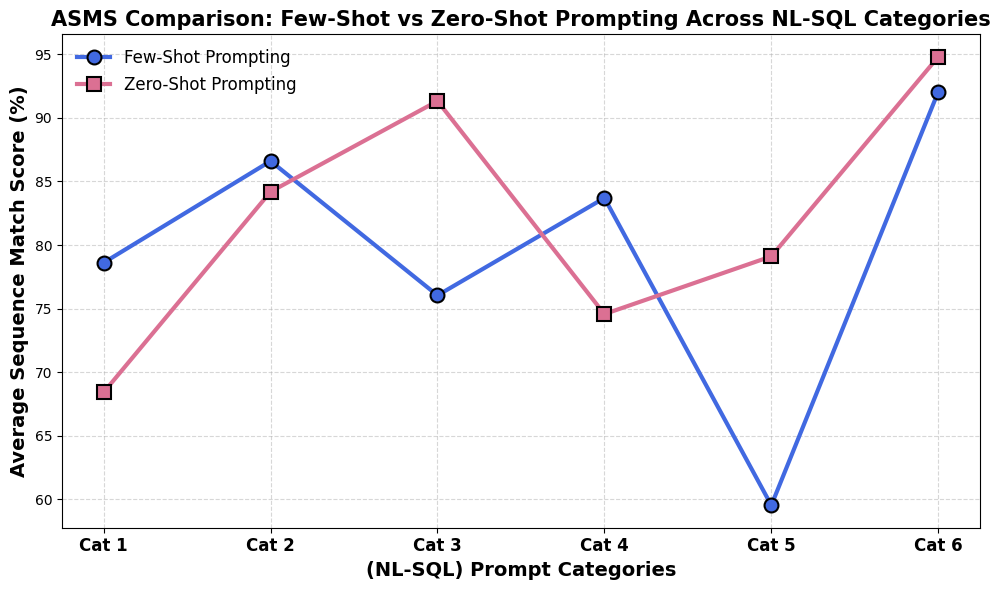

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Defining Categories labels as the x-axis
cat = ["Cat 1", "Cat 2", "Cat 3", "Cat 4", "Cat 5", "Cat 6"]
x = np.arange(len(cat))
#Formatting the obtained ASMS percentages for Few-shot and Zero-shot to be visulasied
few_shot_asms = [78.61, 86.60, 76.04, 83.70, 59.54, 92.05]
zero_shot_asms = [68.42, 84.19, 91.32, 74.57, 79.11, 94.8]
#initilasing figure
plt.figure(figsize=(10,6))
#Plotting the lines with thick linewidth and
plt.plot(x, few_shot_asms, marker='o', markersize=10, markeredgewidth=1.5, markeredgecolor='black', linewidth=3, color='#4169E1', label="Few-Shot Prompting")
plt.plot(x, zero_shot_asms, marker='s', markersize=10, markeredgewidth=1.5, markeredgecolor='black', linewidth=3, color='#DB7093', label="Zero-Shot Prompting")
#Further Formatting the figure
plt.xticks(x, cat, fontsize=12, fontweight='bold')
plt.ylabel("Average Sequence Match Score (%)", fontsize=14, fontweight='bold')
plt.xlabel("(NL-SQL) Prompt Categories", fontsize=14, fontweight='bold')
plt.title("ASMS Comparison: Few-Shot vs Zero-Shot Prompting Across NL-SQL Categories", fontsize=15, fontweight='bold')
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

#Saving the generated figure into a png for display in section 3.0 in the results in the corresponding text
plt.savefig("ASMSfewZeroShot.png", dpi=300, bbox_inches='tight')
plt.show()
files.download("ASMSfewZeroShot.png") #downloading the file from googel collab

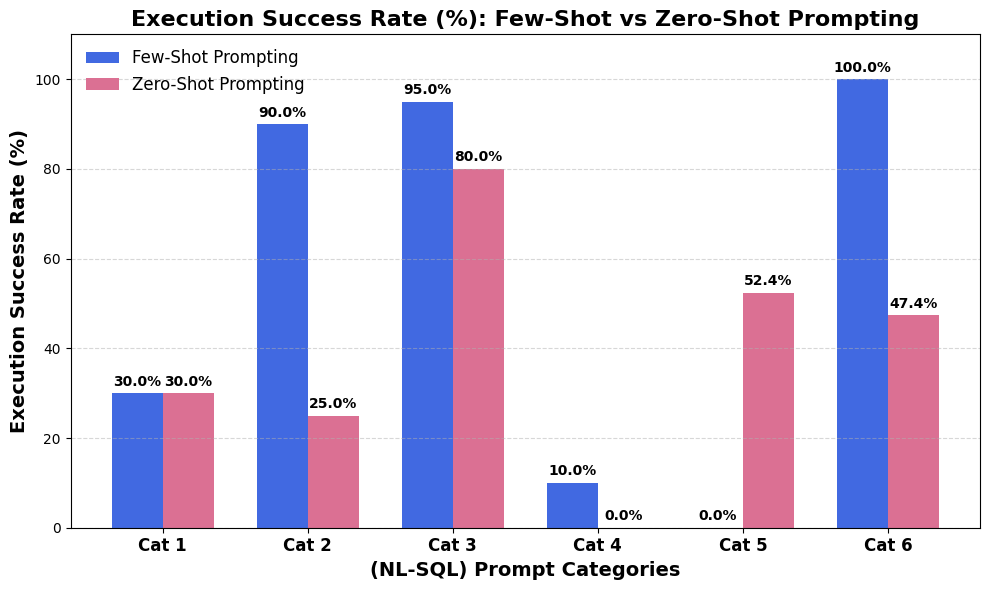

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#ReDefining Categories labels as the x-axis
cat=["Cat 1", "Cat 2", "Cat 3", "Cat 4", "Cat 5", "Cat 6"]
x = np.arange(len(cat))
bw = 0.35  #defining the width
# Converting the number of executions into executions rates
few_shot_exec = [6/20*100, 18/20*100, 19/20*100, 2/20*100, 0/21*100, 19/19*100]
zero_shot_exec = [6/20*100, 5/20*100, 16/20*100, 0/20*100, 11/21*100, 9/19*100]
#intisatialsing the figure
plt.figure(figsize=(10,6))
#Plotting the grouped bars
b1 = plt.bar(x - bw/2, few_shot_exec, width=bw, color='#4169E1', label='Few-Shot Prompting')
b2 = plt.bar(x + bw/2, zero_shot_exec, width=bw, color='#DB7093', label='Zero-Shot Prompting')

#Adding values labels of the executions accuracies to each bar
for bar in b1+b2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Furhther fromatting
plt.xticks(x, categories, fontsize=12, fontweight='bold')
plt.ylabel("Execution Success Rate (%)", fontsize=14, fontweight='bold')
plt.xlabel("(NL-SQL) Prompt Categories", fontsize=14, fontweight='bold')
plt.title("Execution Success Rate (%): Few-Shot vs Zero-Shot Prompting", fontsize=16, fontweight='bold')
plt.ylim(0, 110)
plt.legend(fontsize=12, frameon=False)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

#Saving the generated figure into a png for display in section 3.0 in the results in the corresponding text
plt.savefig("EQbr.png", dpi=300, bbox_inches='tight')
plt.show()
files.download("EQbr.png") #downloading the file from googel collab